In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
import os
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt

In [23]:
# Data Loading
DATA_PATH = "data/"
NUM_IMAGES_TO_USE = 1000
BATCH_SIZE = 100

# Data & Augmentation
IMAGE_SIZE = 64
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Model
LATENT_SIZE = 128
MODEL_VERSION = "v1"
OLD_MODEL_EXISTS = True

# Saving/Loading Model
MODEL_PATH = "model/" + MODEL_VERSION + "/"

# Saving Test Images
NUM_GRIDS_TO_SAVE = 20
NUM_IMAGES_PER_GRID = 64
NUM_ROWS_PER_GRID = 8
SAMPLE_DIR = "generated/test/" + MODEL_VERSION + "/"

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cpu


In [25]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [26]:
real_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=T.Compose([T.Resize(IMAGE_SIZE), 
T.CenterCrop(IMAGE_SIZE),
T.ToTensor(),
T.Normalize(*STATS)]))

real_dataset = Subset(real_dataset, range(NUM_IMAGES_TO_USE))

real_dataloader = DataLoader(real_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
def denormalize(img_tensors):
    return img_tensors *  STATS[1][0] + STATS[0][0]

def show_images(images, nmax=64):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    plt.show()

def show_batch(dl, nmax=64):
    for i, (images, _) in enumerate(dl):
        print(images.shape)
        show_images(images, nmax)
        break

torch.Size([100, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

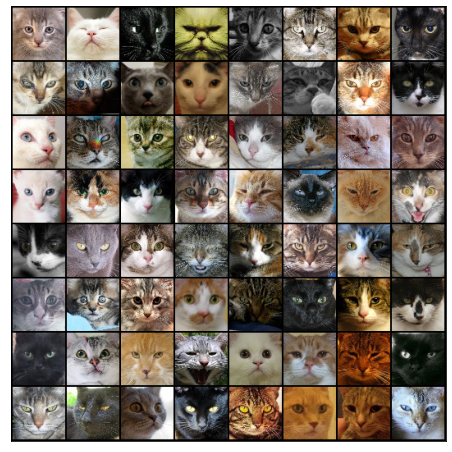

In [28]:
show_batch(real_dataloader)

In [29]:
discriminator = nn.Sequential(
    # in:  3 x 64 x 64

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
).to(device)

In [30]:
generator = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1

    nn.ConvTranspose2d(in_channels=LATENT_SIZE, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    # 3 x 64 x 64
    nn.Tanh()
).to(device)

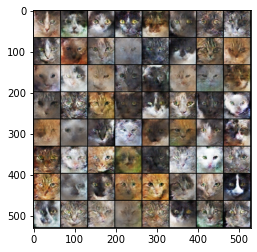

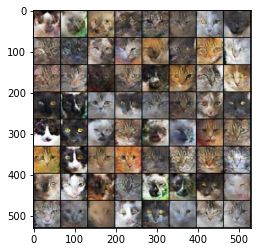

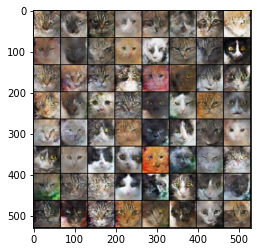

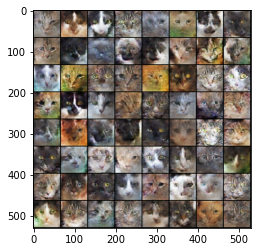

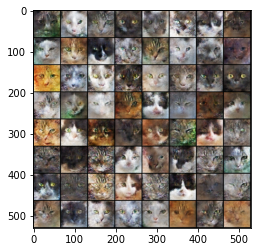

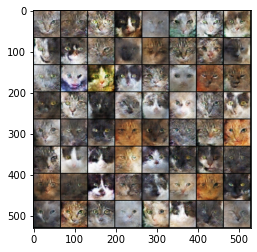

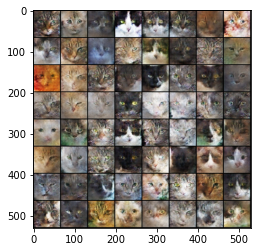

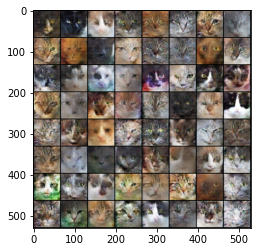

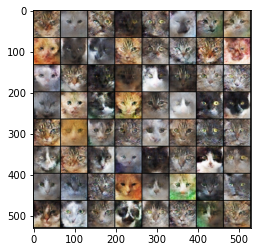

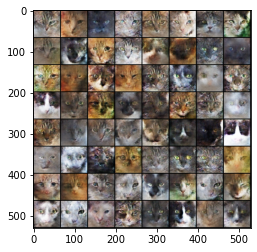

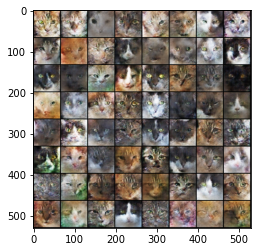

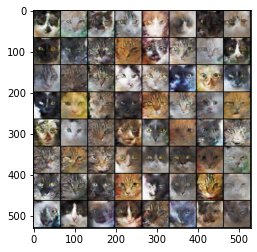

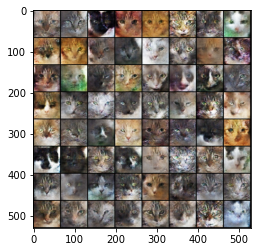

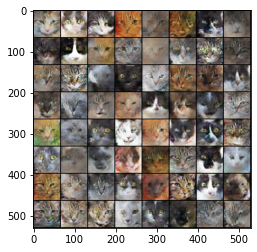

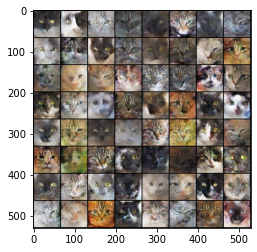

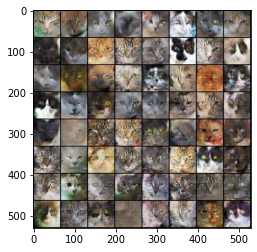

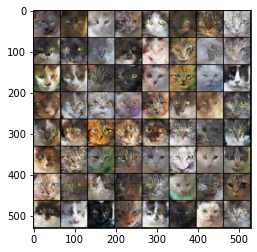

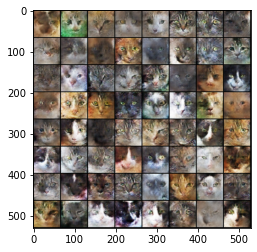

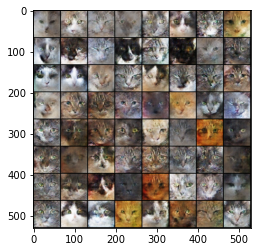

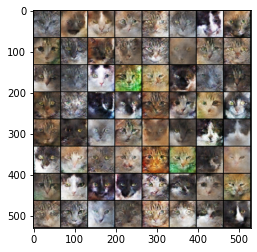

In [31]:
if (OLD_MODEL_EXISTS):
    discriminator.load_state_dict(torch.load(MODEL_PATH + "discriminator.pt"))
    generator.load_state_dict(torch.load(MODEL_PATH + "generator.pt"))

for i in range(NUM_GRIDS_TO_SAVE):
    latent = torch.randn(NUM_IMAGES_PER_GRID, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)
    fake_fname = f"test_image_grid_{i}.png"
    fake_grid = make_grid(denormalize(fake_images.detach()), nrow=NUM_ROWS_PER_GRID)
    save_image(fake_grid, os.path.join(SAMPLE_DIR, fake_fname))
    plt.figure()
    plt.imshow(fake_grid.permute(1,2,0))
    plt.show()